In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [8]:
df_descriptors = pd.read_csv("./data/AqSolDB_Standardized_Mordred.csv")

In [9]:
df_descriptors.head()

,SMILES,Standardized_SMILES,LogS,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,15.325998,11.908140,1,1,0,0,69,...,0.000000,8.878079,54.228660,391.281363,5.670744,2200001716,19,88.0,86.0,5.375000
1,O=C1Nc2cccc3cccc1c23,O=C1Nc2cccc3cccc1c23,-3.254767,10.554231,8.981734,0,0,10,11,20,...,7.050123,9.744550,59.616539,169.052764,8.452638,207,21,74.0,91.0,2.777778
2,Clc1ccc(C=O)cc1,O=Cc1ccc(Cl)cc1,-2.177078,6.473351,6.127583,0,0,6,6,14,...,0.000000,8.590258,37.289972,140.002892,10.000207,90,9,40.0,43.0,2.166667
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,40.125716,33.290350,2,0,36,36,95,...,0.000000,10.862704,91.421759,754.227281,7.939235,72800003204,86,268.0,316.0,11.555556
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065,25.374964,18.024219,0,0,12,12,61,...,8.486528,10.351150,90.719091,422.220557,6.921648,3248,42,174.0,206.0,6.555556


In [12]:
# Extract features (X) and target (y)

X = df_descriptors.iloc[:, 3:]  # columns after first 5 are Mordred descriptors
y = df_descriptors['LogS']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (9982, 642)
Target shape: (9982,)


In [13]:
X.head()

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,15.325998,11.908140,1,1,0,0,69,23,0,0,...,0.000000,8.878079,54.228660,391.281363,5.670744,2200001716,19,88.0,86.0,5.375000
1,10.554231,8.981734,0,0,10,11,20,13,0,0,...,7.050123,9.744550,59.616539,169.052764,8.452638,207,21,74.0,91.0,2.777778
2,6.473351,6.127583,0,0,6,6,14,9,0,0,...,0.000000,8.590258,37.289972,140.002892,10.000207,90,9,40.0,43.0,2.166667
3,40.125716,33.290350,2,0,36,36,95,53,0,0,...,0.000000,10.862704,91.421759,754.227281,7.939235,72800003204,86,268.0,316.0,11.555556
4,25.374964,18.024219,0,0,12,12,61,31,0,0,...,8.486528,10.351150,90.719091,422.220557,6.921648,3248,42,174.0,206.0,6.555556


In [14]:
y.head()

0   -3.616127
1   -3.254767
2   -2.177078
3   -3.924409
4   -4.662065
Name: LogS, dtype: float64

In [15]:
# Keep only numerics
X = X.select_dtypes(include=[np.number])  
X = X.replace([np.inf, -np.inf], np.nan)

# Keep columns with at least 80% nonNaN values
X = X.dropna(axis=1, thresh=0.8 * len(X))  
X = X.fillna(X.mean())

print(f"Features after cleaning: {X.shape}")

Features after cleaning: (9982, 640)


In [16]:
# Split train-test da
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

print(f"Training set: {X_train.shape[0]} molecules")
print(f"Test set: {X_test.shape[0]} molecules")

Training set: 7985 molecules
Test set: 1997 molecules


In [17]:
# Scale the data
print("Scaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling data...


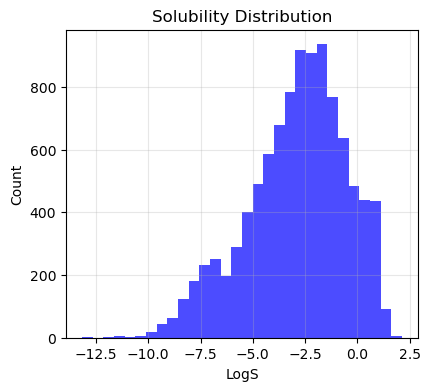

In [18]:
# Solubility distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=30, alpha=0.7, color='blue')
plt.xlabel('LogS')
plt.ylabel('Count')
plt.title('Solubility Distribution')
plt.grid(True, alpha=0.3)

In [19]:
# Train SVM model
print("Training SVM model...")

svm_model = SVR(kernel = 'rbf', C = 1.0, epsilon = 0.1 , gamma = 'scale') # Got good results with defaults

svm_model.fit(X_train_scaled, y_train)

print("SVM training completed!")

Training SVM model...
SVM training completed!


In [20]:
# Evaluate w/ epsilon 0.1 and C = 1.0
y_pred_test = svm_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(
    "SVM's Performance on Test Set:\n"
    f"  Mean Absolute Error:      {mae:.3f}\n"
    f"  R²:                       {r2:.3f}\n"
    f"  Root Mean Squared Error:  {rmse:.3f}"
)


SVM's Performance on Test Set:
  Mean Absolute Error:      0.756
  R²:                       0.785
  Root Mean Squared Error:  1.080


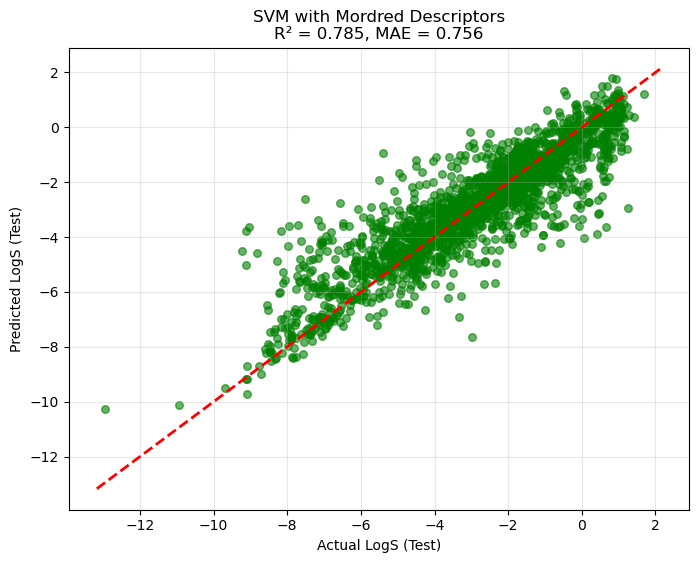

In [21]:
# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=30, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual LogS (Test)')
plt.ylabel('Predicted LogS (Test)')
plt.title(f'SVM with Mordred Descriptors\nR² = {r2:.3f}, MAE = {mae:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
# Save model
import joblib
model_data = {
    'model': svm_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist()
}
joblib.dump(model_data, 'svm_solubility_model.pkl')
print("Model saved as 'svm_solubility_model.pkl'")

Model saved as 'svm_solubility_model.pkl'
